# Exploring the Open Reaction Database (ORD)
## Case Study: Ligand Effects in Ni-Catalyzed Suzuki-Miyaura Coupling

**Goal:** Demonstrate how the ORD's structured schema enables systematic comparison of reaction conditions across hundreds of experiments.

---

## 1. What is ORD?

The **Open Reaction Database** is a structured, open-access repository for chemical reaction data that:

- Uses a **standardized schema** (Protocol Buffers) to store reaction details
-  Captures comprehensive experimental data: reactants, catalysts, conditions, yields
- Enables **machine learning** and data-driven chemistry
- Makes reaction data **FAIR** (Findable, Accessible, Interoperable, Reusable)

### Why Schema Matters

**Traditional (Unstructured):**
```
"The reaction was heated to 80°C for 2 hours with Pd catalyst in THF"
```

**ORD (Structured):**
```python
{
  "temperature": {"value": 80, "units": "CELSIUS"},
  "time": {"value": 2, "units": "HOUR"},
  "catalyst": {"name": "Pd(PPh3)4", "amount": {...}},
  "solvent": {"name": "THF", "volume": {...}}
}
```

Machine-readable | Unambiguous | Comparable across 1000s of reactions

---

## 2. Loading ORD Data

Analysys a dataset called  **Ni-catalyzed Suzuki-Miyaura coupling reactions** with systematic ligand variation.

In [164]:
# Core imports
from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2
import gzip

# Visualization
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Better plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [165]:
# Load the dataset (Suzuki-Miyaura coupling data)
with gzip.open(
    "ord-data/data/3b/ord_dataset-3b5db90e337942ea886b8f5bc5e3aa72.pb.gz",
    "rb"
) as f:
    dataset = dataset_pb2.Dataset()
    dataset.ParseFromString(f.read())

print(f"Loaded {len(dataset.reactions)} reactions")

Loaded 450 reactions


## 3. Understanding the Schema

The ORD schema organizes reaction data into **9 main sections**:

```
Reaction
├── Identifiers (reaction IDs, DOIs)
├── Inputs (reactants, catalysts, solvents, ligands)
├── Setup (vessel type, atmosphere)
├── Conditions (temperature, pressure, stirring)
├── Notes (observations)
├── Observations (color changes, etc.)
├── Workups (purification steps)
├── Outcomes (products, yields, analytics)
└── Provenance (who, when, where)
```

In [166]:
# Helper function for accessing Protocol Buffer enums
def get_enum_name(proto_obj, field_name):
    """Get the string name of an enum field from a Protocol Buffer object."""
    field_value = getattr(proto_obj, field_name)
    enum_descriptor = proto_obj.DESCRIPTOR.fields_by_name[field_name].enum_type
    return enum_descriptor.values_by_number[field_value].name

def get_yield(reaction):
    """Extract yield percentage from a reaction."""
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for m in product.measurements:
                if get_enum_name(m, "type") == "YIELD" and m.HasField("percentage"):
                    return float(m.percentage.value)
    return None

def get_component_names(reaction, role):
    """Extract component names by role (CATALYST, LIGAND, REACTANT, etc.)."""
    names = []
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            if get_enum_name(comp, "reaction_role") == role:
                for ident in comp.identifiers:
                    if get_enum_name(ident, "type") == "NAME":
                        names.append(ident.value)
                        break
    return names

## 4. Example: Detailed View of One Reaction

Let's examine reaction #0 in detail to see what information the schema captures.

In [167]:
# schema of a reaction
r = dataset.reactions[0]

print("Schema Structure \n")

# 1. Inputs 
print("1. Inputs (Reactants, Catalysts, Solvents)")
for input_key, input_val in r.inputs.items():
    print(f"   Input: {input_key}")
    for comp in input_val.components:
        # Get the role 
        role = comp.DESCRIPTOR.fields_by_name["reaction_role"].enum_type.values_by_number[comp.reaction_role].name
        print(f"     - Role: {role}")
        
        # Get amount (structured data)
        if comp.HasField("amount"):
            if comp.amount.HasField("moles"):
                print(f"       Amount: {comp.amount.moles.value} {comp.amount.moles.units}")
            elif comp.amount.HasField("mass"):
                print(f"       Amount: {comp.amount.mass.value} g")
        
        # Get identifier
        for ident in comp.identifiers:
            itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
            if itype == "SMILES":
                print(f"       SMILES: {ident.value}")
        break  
    break  
# 2. Conditions 
print("\n2. Conditions (Temperature, Pressure, Stirring)")
if r.conditions.HasField("temperature"):
    if r.conditions.temperature.HasField("setpoint"):
        temp = r.conditions.temperature.setpoint
        print(f"   Temperature: {temp.value}°C")

if r.conditions.HasField("stirring"):
    stir_type = r.conditions.stirring.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[r.conditions.stirring.type].name
    print(f"   Stirring: {stir_type}")

# 3. Outcomes 
print("\n3. Outcomes (Products, Yields)")
for outcome in r.outcomes:
    print(f"   Reaction time: {outcome.reaction_time.value} hours")
    for product in outcome.products:
        print(f"   Product:")
        for ident in product.identifiers:
            itype = ident.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[ident.type].name
            if itype == "SMILES":
                print(f"     SMILES: {ident.value}")
        
        for measurement in product.measurements:
            mtype = measurement.DESCRIPTOR.fields_by_name["type"].enum_type.values_by_number[measurement.type].name
            if mtype == "YIELD" and measurement.HasField("percentage"):
                print(f"     Yield: {measurement.percentage.value}%")
        break 
    break  
print("\nAvailable Fields in Reaction")
reaction_fields = dataset.reactions[0].DESCRIPTOR.fields_by_name.keys()
for field in sorted(reaction_fields):
    print(f"  - {field}")
   

Schema Structure 

1. Inputs (Reactants, Catalysts, Solvents)
   Input: aryl chloride in dioxane
     - Role: REACTANT
       Amount: 8.0 3
       SMILES: ClC1=CC=C(OC)C=C1

2. Conditions (Temperature, Pressure, Stirring)
   Temperature: 60.0°C
   Stirring: STIR_BAR

3. Outcomes (Products, Yields)
   Reaction time: 2.0 hours
   Product:
     SMILES: FC(C(C=C1)=CC=C1C2=CC=C(OC)C=C2)(F)F
     Yield: 3.0%

Available Fields in Reaction
  - conditions
  - identifiers
  - inputs
  - notes
  - observations
  - outcomes
  - provenance
  - reaction_id
  - setup
  - workups


### Visualize the Reaction

Reactants:
  aryl chloride in dioxane: ClC1=CC=C(OC)C=C1
  boronic acid + water in dioxane: OB(O)C1=C(C)C=C(C)C=C1C

Products:
  Product: CC1=CC(C)=CC(C)=C1C2=CC=C(OC)C=C2


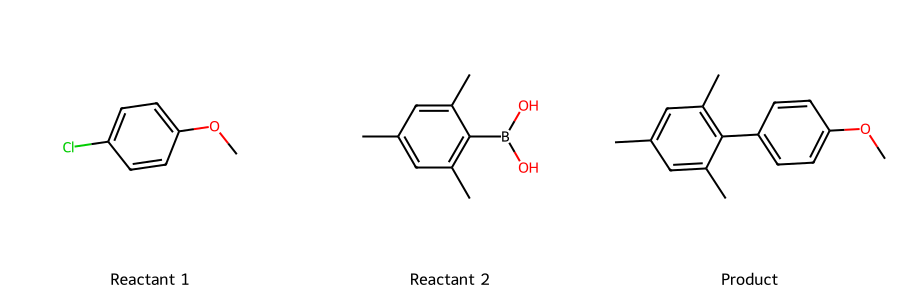

In [168]:
# Change this number to see different reactions
reaction_index = 90

r = dataset.reactions[reaction_index]

def visualize_reaction(reaction):
    """Draw reactants and products of a reaction."""
    mols = []
    legends = []
    
    # Get reactants
    print("Reactants:")
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            if get_enum_name(comp, "reaction_role") == "REACTANT":
                for ident in comp.identifiers:
                    if get_enum_name(ident, "type") == "SMILES":
                        smiles = ident.value
                        mol = Chem.MolFromSmiles(smiles)
                        if mol:
                            mols.append(mol)
                            legends.append(f"Reactant {len(mols)}")
                            print(f"  {key}: {smiles}")
                        break
    
    # Get product
    print("\nProducts:")
    for outcome in reaction.outcomes:
        for product in outcome.products:
            if product.is_desired_product:
                for ident in product.identifiers:
                    if get_enum_name(ident, "type") == "SMILES":
                        smiles = ident.value
                        mol = Chem.MolFromSmiles(smiles)
                        if mol:
                            mols.append(mol)
                            legends.append("Product")
                            print(f"  Product: {smiles}")
                        break
                break
        break
    
    if mols:
        return Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300,300), legends=legends)
    return None

img = visualize_reaction(r)
if img:
    display(img)

Ligands in reaction 0:
1) CPhos
   SMILES: CN(c1cccc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)N(C)C)C


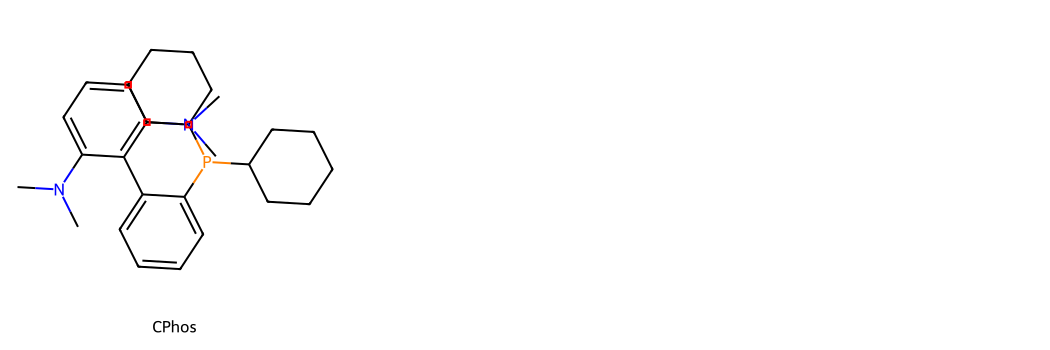

In [169]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Change this number to see different reactions
reaction_index = 0

r = dataset.reactions[reaction_index]

# Extract ligands (CATALYST components except Ni source)
ligands = []  # (name, smiles)

for inp in r.inputs.values():
    for comp in inp.components:
        role = get_enum_name(comp, "reaction_role")
        if role != "CATALYST":
            continue

        name, smiles = None, None
        for ident in comp.identifiers:
            idtype = get_enum_name(ident, "type")
            if idtype == "NAME":
                name = ident.value
            elif idtype == "SMILES":
                smiles = ident.value

        # Skip Ni source, keep ligand
        if name and "Ni" in name:
            continue
        if smiles:
            ligands.append((name if name else "Ligand", smiles))

# Deduplicate by SMILES
seen = set()
uniq = []
for name, smi in ligands:
    if smi not in seen:
        seen.add(smi)
        uniq.append((name, smi))

# Print and visualize
print(f"Ligands in reaction {reaction_index}:")
if not uniq:
    print("No ligand found.")
else:
    for i, (name, smi) in enumerate(uniq, 1):
        print(f"{i}) {name}")
        print(f"   SMILES: {smi}")

    # Visualize
    mols = [Chem.MolFromSmiles(smi) for _, smi in uniq]
    legends = [name for name, _ in uniq]
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(350, 350), legends=legends)
    display(img)

## 5. Dataset Overview: Yield Distribution

Extract all yields from the dataset to understand the overall success rate.

In [170]:
# Extract all yields
yields = []
for r in dataset.reactions:
    yld = get_yield(r)
    if yld is not None:
        yields.append(yld)

print(f"Total reactions with yield data: {len(yields)}")
print(f"Mean yield: {np.mean(yields):.1f}%")
print(f"Median yield: {np.median(yields):.1f}%")
print(f"High-yield reactions (>80%): {sum(y > 80 for y in yields)} ({sum(y > 80 for y in yields)/len(yields)*100:.1f}%)")

Total reactions with yield data: 450
Mean yield: 18.3%
Median yield: 6.0%
High-yield reactions (>80%): 17 (3.8%)


/tmp/ipykernel_22506/692560707.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=11)


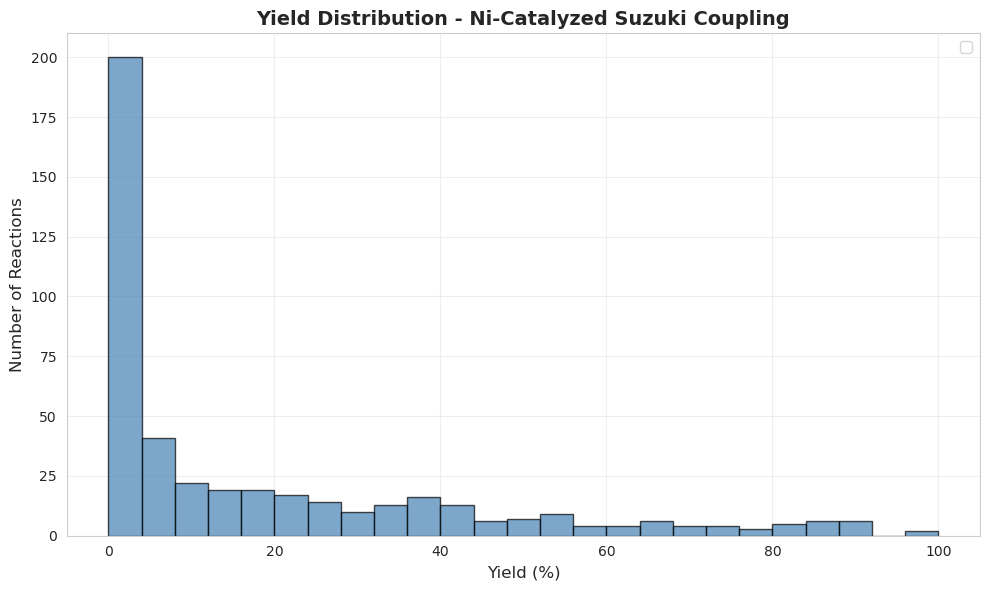

In [171]:
# Visualize yield distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(yields, bins=25, color='steelblue', edgecolor='black', alpha=0.7)

ax.set_xlabel('Yield (%)', fontsize=12)
ax.set_ylabel('Number of Reactions', fontsize=12)
ax.set_title('Yield Distribution - Ni-Catalyzed Suzuki Coupling', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Insight #1

This dataset includes **both successful and unsuccessful reactions**.

This is crucial for machine learning models to learn:
- What works
- What doesn't work
- The full spectrum of reactivity

---

## 6. Main Analysis: Ligand Effect on Yield

**Research Question:** Which phosphine ligands give the best yields in Ni-catalyzed Suzuki coupling?

The structured schema makes it easy to group reactions by ligand and compare yields.

In [172]:
# Group reactions by ligand
from collections import defaultdict

ligand_yields = defaultdict(list)

for r in dataset.reactions:
    yld = get_yield(r)
    if yld is None:
        continue
    
    # Get catalyst names (both Ni source and ligand)
    catalysts = get_component_names(r, "CATALYST")
    
    # Extract ligand (skip Ni source)
    ligands = [cat for cat in catalysts if "Ni" not in cat]
    
    if ligands:
        ligand = ligands[0]  # Take first ligand
        ligand_yields[ligand].append(yld)

print(f" {len(ligand_yields)} unique ligands")

# Calculate average yields
ligand_avg = {lig: np.mean(ylds) for lig, ylds in ligand_yields.items()}

# Sort by average yield
sorted_ligands = sorted(ligand_avg.items(), key=lambda x: x[1], reverse=True)

# Top 10
print("\n Top 10 Ligands by Average Yield:")
print("="*60)
for i, (lig, avg_yld) in enumerate(sorted_ligands[:10], 1):
    n_reactions = len(ligand_yields[lig])
    print(f"{i:2}. {lig[:40]:40} {avg_yld:5.1f}% (n={n_reactions})")

 90 unique ligands

 Top 10 Ligands by Average Yield:
 1. PCy(3,5-tBu2-Ph)2                         67.8% (n=5)
 2. PCyp(3,5-tBu2-Ph)2                        67.2% (n=5)
 3. P(3,5-tBu2-Ph)3                           65.6% (n=5)
 4. PPh(3,5-tBu2-Ph)2                         65.2% (n=5)
 5. P(exo-norbornenyl)(3,5-tBu2-Ph)2          56.2% (n=5)
 6. PCyp(3,5-Me2-Ph)2                         56.0% (n=5)
 7. CyJohnPhos                                53.6% (n=5)
 8. PmTol3                                    52.2% (n=5)
 9. NPh-Pyrrole-PCy2, CataCXiumPCy            50.8% (n=5)
10. PCH2Cyp(3,5-tBu2-Ph)2                     50.6% (n=5)


### Visualize Top Ligands

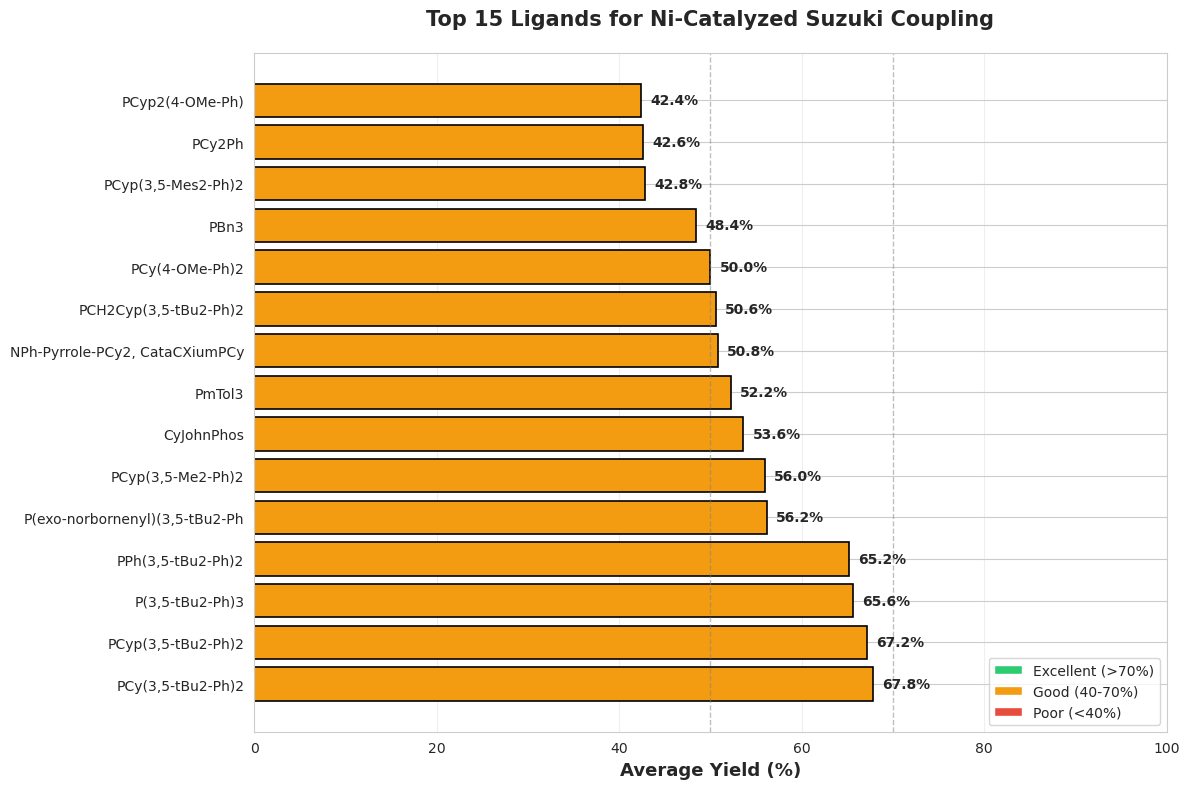

In [173]:
# Prepare data for visualization
top_n = 15
top_ligands = sorted_ligands[:top_n]

labels = [lig[:30] for lig, _ in top_ligands]  # Truncate long names
values = [avg for _, avg in top_ligands]
colors = ['#2ecc71' if v > 70 else '#f39c12' if v > 40 else '#e74c3c' for v in values]

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(labels, values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, values)):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=10, fontweight='bold')

# Add reference lines
ax.axvline(50, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(70, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Average Yield (%)', fontsize=13, fontweight='bold')
ax.set_title('Top 15 Ligands for Ni-Catalyzed Suzuki Coupling', fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Excellent (>70%)'),
    Patch(facecolor='#f39c12', label='Good (40-70%)'),
    Patch(facecolor='#e74c3c', label='Poor (<40%)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

### Key Insight #2: Clear Ligand Trends

The structured ORD data reveals:

1. **Best performers** 
2. **Poor performers** 
3. **Wide variation**

This type of systematic comparison would be **impossible** with unstructured literature data!

---

## 8. Conclusions

### What was Demonstrated:

1. **Schema Power:** ORD's structured format enables systematic analysis across hundreds of reactions
2. **Machine-Readable:** All data is accessible programmatically via Python
3. **Research Insights:** Clear trends in ligand effects that guide experimental design
4. **Complete Picture:** Both successful and unsuccessful reactions included

### Why This Matters:

- **Machine Learning:** Structured data is essential for training predictive models
- **Research:** Easy comparison across conditions, substrates, catalysts
- **Reproducibility:** Complete experimental details in standardized format
- **Collaboration:** Open access enables community-driven discovery

### Next Steps:

- Build yield prediction models
- Analyze substrate scope systematically
- Compare different reaction classes
- Contribute your own data to ORD!

---

**Resources:**
- ORD Website: https://open-reaction-database.org/
- GitHub: https://github.com/open-reaction-database
- Documentation: https://docs.open-reaction-database.org/
- Paper: Kearnes et al., *J. Am. Chem. Soc.* **2021**, *143*, 18820-18826
